In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import pickle as pkl
import time
import os
import tensorflow_hub as hub
from tensorflow.errors import InvalidArgumentError

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


Using TensorFlow backend.


In [2]:
class_mapping = {}
with open('../dbpedia_csv/classes.txt') as txt_file:
    line_num = 0
    for line in txt_file:
        class_mapping[line_num] = line.strip()
        line_num+=1
        
print(class_mapping)

{0: 'Company', 1: 'EducationalInstitution', 2: 'Artist', 3: 'Athlete', 4: 'OfficeHolder', 5: 'MeanOfTransportation', 6: 'Building', 7: 'NaturalPlace', 8: 'Village', 9: 'Animal', 10: 'Plant', 11: 'Album', 12: 'Film', 13: 'WrittenWork'}


### Create Data Generator

In [ ]:
class USEDataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size = 32, n_classes=14, shuffle=True):
        self.dim = (1,)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index:(index+1)]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X,y = self.__data_generation(list_IDs_temp)
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        X = []
        y = np.empty((self.batch_size), dtype = int)
        for item in list_IDs_temp:
            Xarray = pkl.load(open('../Training/'+item, 'rb'))
        for i, row in enumerate(Xarray[1]):
            X.append(' '.join(row))
            y[i] = Xarray[0]-1
        X = np.array(X,dtype = object)[:,np.newaxis]
        
        return X, keras.utils.to_categorical(y, num_classes = self.n_classes)

In [ ]:
params = {'batch_size':32, 'n_classes':14,'shuffle':True}
partition, labels = pkl.load(open('../Training/Metadata', 'rb'))
for key in labels.keys():
    labels[key] -= 1
training_generator = USEDataGenerator(partition['train'], **params)

### Create Keras layer from TF-hub module

In [ ]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)),signature='default', as_dict=True)['default']

In [ ]:
input_text = keras.layers.Input(shape=(1,), dtype = tf.string)
embedding = keras.layers.Lambda(UniversalEmbedding, output_shape = (512, ))(input_text)
dense = keras.layers.Dense(256, activation='relu')(embedding)
pred = keras.layers.Dense(14, activation = 'softmax')(dense)
model = keras.models.Model(inputs = [input_text], outputs = pred)
model.compile(loss= 'categorical_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

model.name = 'USE_model'

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit_generator(generator = training_generator, epochs = 1, verbose = 1)
    model.save_weights('./'+model.name+'.h5')
    start = time.time()
    accuracies = {}
    for label in os.listdir('../Testing'):
        accuracies[label] = {}
        for sent_len in os.listdir('../Testing/{}'.format(label)):
            Xtest = []
            labels = []
            if int(sent_len) < 100:
                for file in os.listdir('../Testing/{}/{}'.format(label, sent_len)):
                    sample = pkl.load(open('../Testing/{}/{}/{}'.format(label, sent_len, file),'rb'))
                    labels.append(sample[0])
                    Xtest.append(' '.join(sample[1]))
                Xtest = np.array(Xtest, dtype = object)[:,np.newaxis]
                result = np.asarray(model.predict(Xtest))
                result = np.argmax(result, axis = 1)+1
                accuracy = np.sum(result == labels)/len(labels)
                print('{}, sentence_length:{}, Accuracy:{}'.format(label, sent_len,accuracy))
                accuracies[label][sent_len] = accuracy
                print('elapsed time: {}'.format((time.time()-start)/60))
        pkl.dump(accuracies, open('USEaccuracy', 'wb'))

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./'+model.name+'.h5')  
    accuracies = pkl.load(open('USEaccuracy', 'rb'))
    start = time.time()
    for label in os.listdir('../Testing'):
        if label not in accuracies.keys():
            accuracies[label] = {}
        for sent_len in os.listdir('../Testing/{}'.format(label)):
            if sent_len not in accuracies[label].keys():
                Xtest = []
                labels = []
                if int(sent_len) < 100:
                    for file in os.listdir('../Testing/{}/{}'.format(label, sent_len)):
                        sample = pkl.load(open('../Testing/{}/{}/{}'.format(label, sent_len, file),'rb'))
                        labels.append(sample[0])
                        Xtest.append(' '.join(sample[1]))
                    Xtest = np.array(Xtest, dtype = object)[:,np.newaxis]
                    try:
                        result = np.asarray(model.predict(Xtest))
                        result = np.argmax(result, axis = 1)+1
                        accuracy = np.sum(result == labels)/len(labels)
                        print('{}, sentence_length:{}, Accuracy:{}'.format(label, sent_len,accuracy))
                        accuracies[label][sent_len] = accuracy
                    except InvalidArgumentError:
                        print("Error with {} Sentence Length: {}".format(label, sent_len))
                        pass
                    print('elapsed time: {}'.format((time.time()-start)/60))
            pkl.dump(accuracies, open('USEaccuracy', 'wb'))

In [3]:
accs = pkl.load(open('USEaccuracy', 'rb'))
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns),key = int), axis = 1).transpose()

for item in accuracies.keys():
    for i in range(len(accuracies[item])):
        if np.isnan(accuracies[item][i]):
            if i == 0:
                accuracies[item][i] == accuracies[item][i+1]
            if i == len(accuracies[item])-1:
                accuracies[item][i] == accuracies[item][i-1]
            else:
                accuracies[item][i] = (accuracies[item][i-1]+accuracies[item][i+1])/2

def impute_missing(accuracies, item, i):
    if i == 0:
        return(accuracies[item][i+1])
    if i == len(accuracies[item])-1:
        return(accuracies[item][i-3])
    else:
        if np.isnan(accuracies[item][i-1]):
            accuracies[item][i-1] = impute_missing(accuracies,item,i-1)
        if np.isnan(accuracies[item][i+1]):
            accuracies[item][i+1] = impute_missing(accuracies,item,i+1)
        return((accuracies[item][i-1]+accuracies[item][i+1])/2)
    
def fill_missing(accuracies):
    for item in accuracies.keys():
        print(len(accuracies[item]))
        for i in range(len(accuracies[item])):
            if np.isnan(accuracies[item][i]):
                if i> len(accuracies[item])-5:
                    accuracies[item][i] = accuracies[item][i-1]
                else:
                    accuracies[item][i] = impute_missing(accuracies, item, i)

accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)

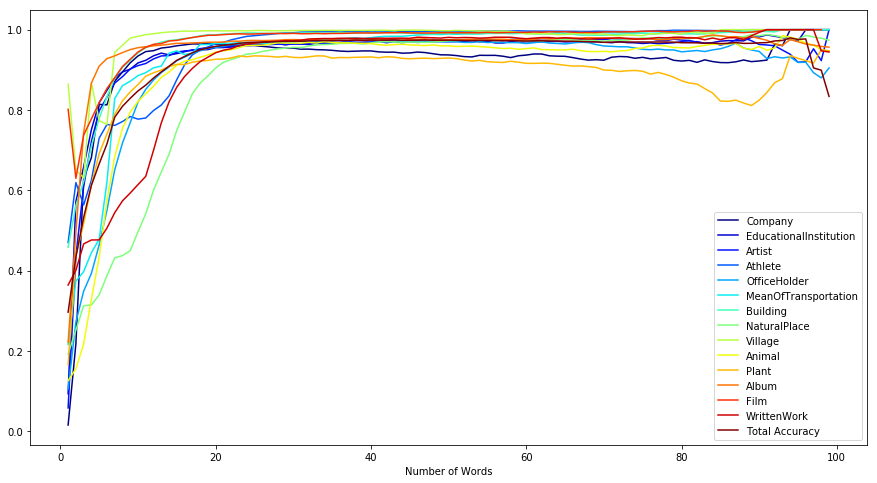

In [4]:
accuracies.plot(x = 'Number of Words', figsize = (15,8), colormap = 'jet')
plt.show()

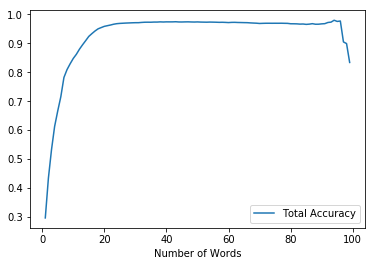

In [5]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy')
plt.show()